# Default of payments

Tasks:
- Propose a ML classifier exploiting a random forest, and a random forest AFTER exploiting a Lasso regression to reduce the number of features; compare the two classifiers. Always choose
the optimal hyperparameters.
- Use Interpretability tools to explain the predictions.

---

# 1.  Data Analysis and Preprocessing

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV, Lasso
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import shap

In [4]:
# Load the data
file_path = './Dataset3.csv'
data = pd.read_csv(file_path, delimiter=';')

In [5]:
data.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


# Data Cleaning

Check consistency in categorical variables

In [61]:
data['MARRIAGE'].unique()

array([1, 2, 3, 0])

In [63]:
# Correct inconsistent values in the MARRIAGE variable
data['MARRIAGE'] = data['MARRIAGE'].replace(0, 3)  # Assuming 0 is unknown, treat it as others
unique_marriage = data['MARRIAGE'].unique()
unique_marriage

array([1, 2, 3])

In [64]:
data['EDUCATION'].unique()

array([2, 1, 3, 5, 4, 6, 0])

In [65]:
# Correct inconsistent values in the EDUCATION variable
data['EDUCATION'] = data['EDUCATION'].replace([0, 5, 6], 4)  # Group 0, 5, and 6 into others
unique_education = data['EDUCATION'].unique()
unique_education

array([2, 1, 3, 4])

In [68]:
data['SEX'].unique()


array([2, 1])

## Dataset Exploration

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ID                          30000 non-null  int64  
 1   LIMIT_BAL                   30000 non-null  float64
 2   SEX                         30000 non-null  int64  
 3   EDUCATION                   30000 non-null  int64  
 4   MARRIAGE                    30000 non-null  int64  
 5   AGE                         30000 non-null  int64  
 6   PAY_0                       30000 non-null  int64  
 7   PAY_2                       30000 non-null  int64  
 8   PAY_3                       30000 non-null  int64  
 9   PAY_4                       30000 non-null  int64  
 10  PAY_5                       30000 non-null  int64  
 11  PAY_6                       30000 non-null  int64  
 12  BILL_AMT1                   30000 non-null  float64
 13  BILL_AMT2                   300

In [70]:
data.describe()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,...,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,15000.500000,167484.322667,1.603733,1.842267,1.557267,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,...,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,8660.398374,129747.661567,0.489129,0.744494,0.521405,9.217904,1.123802,1.197186,1.196868,1.169139,...,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,1.000000,10000.000000,1.000000,1.000000,1.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,7500.750000,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,15000.500000,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,...,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,22500.250000,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,...,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,30000.000000,1000000.000000,2.000000,4.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,...,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


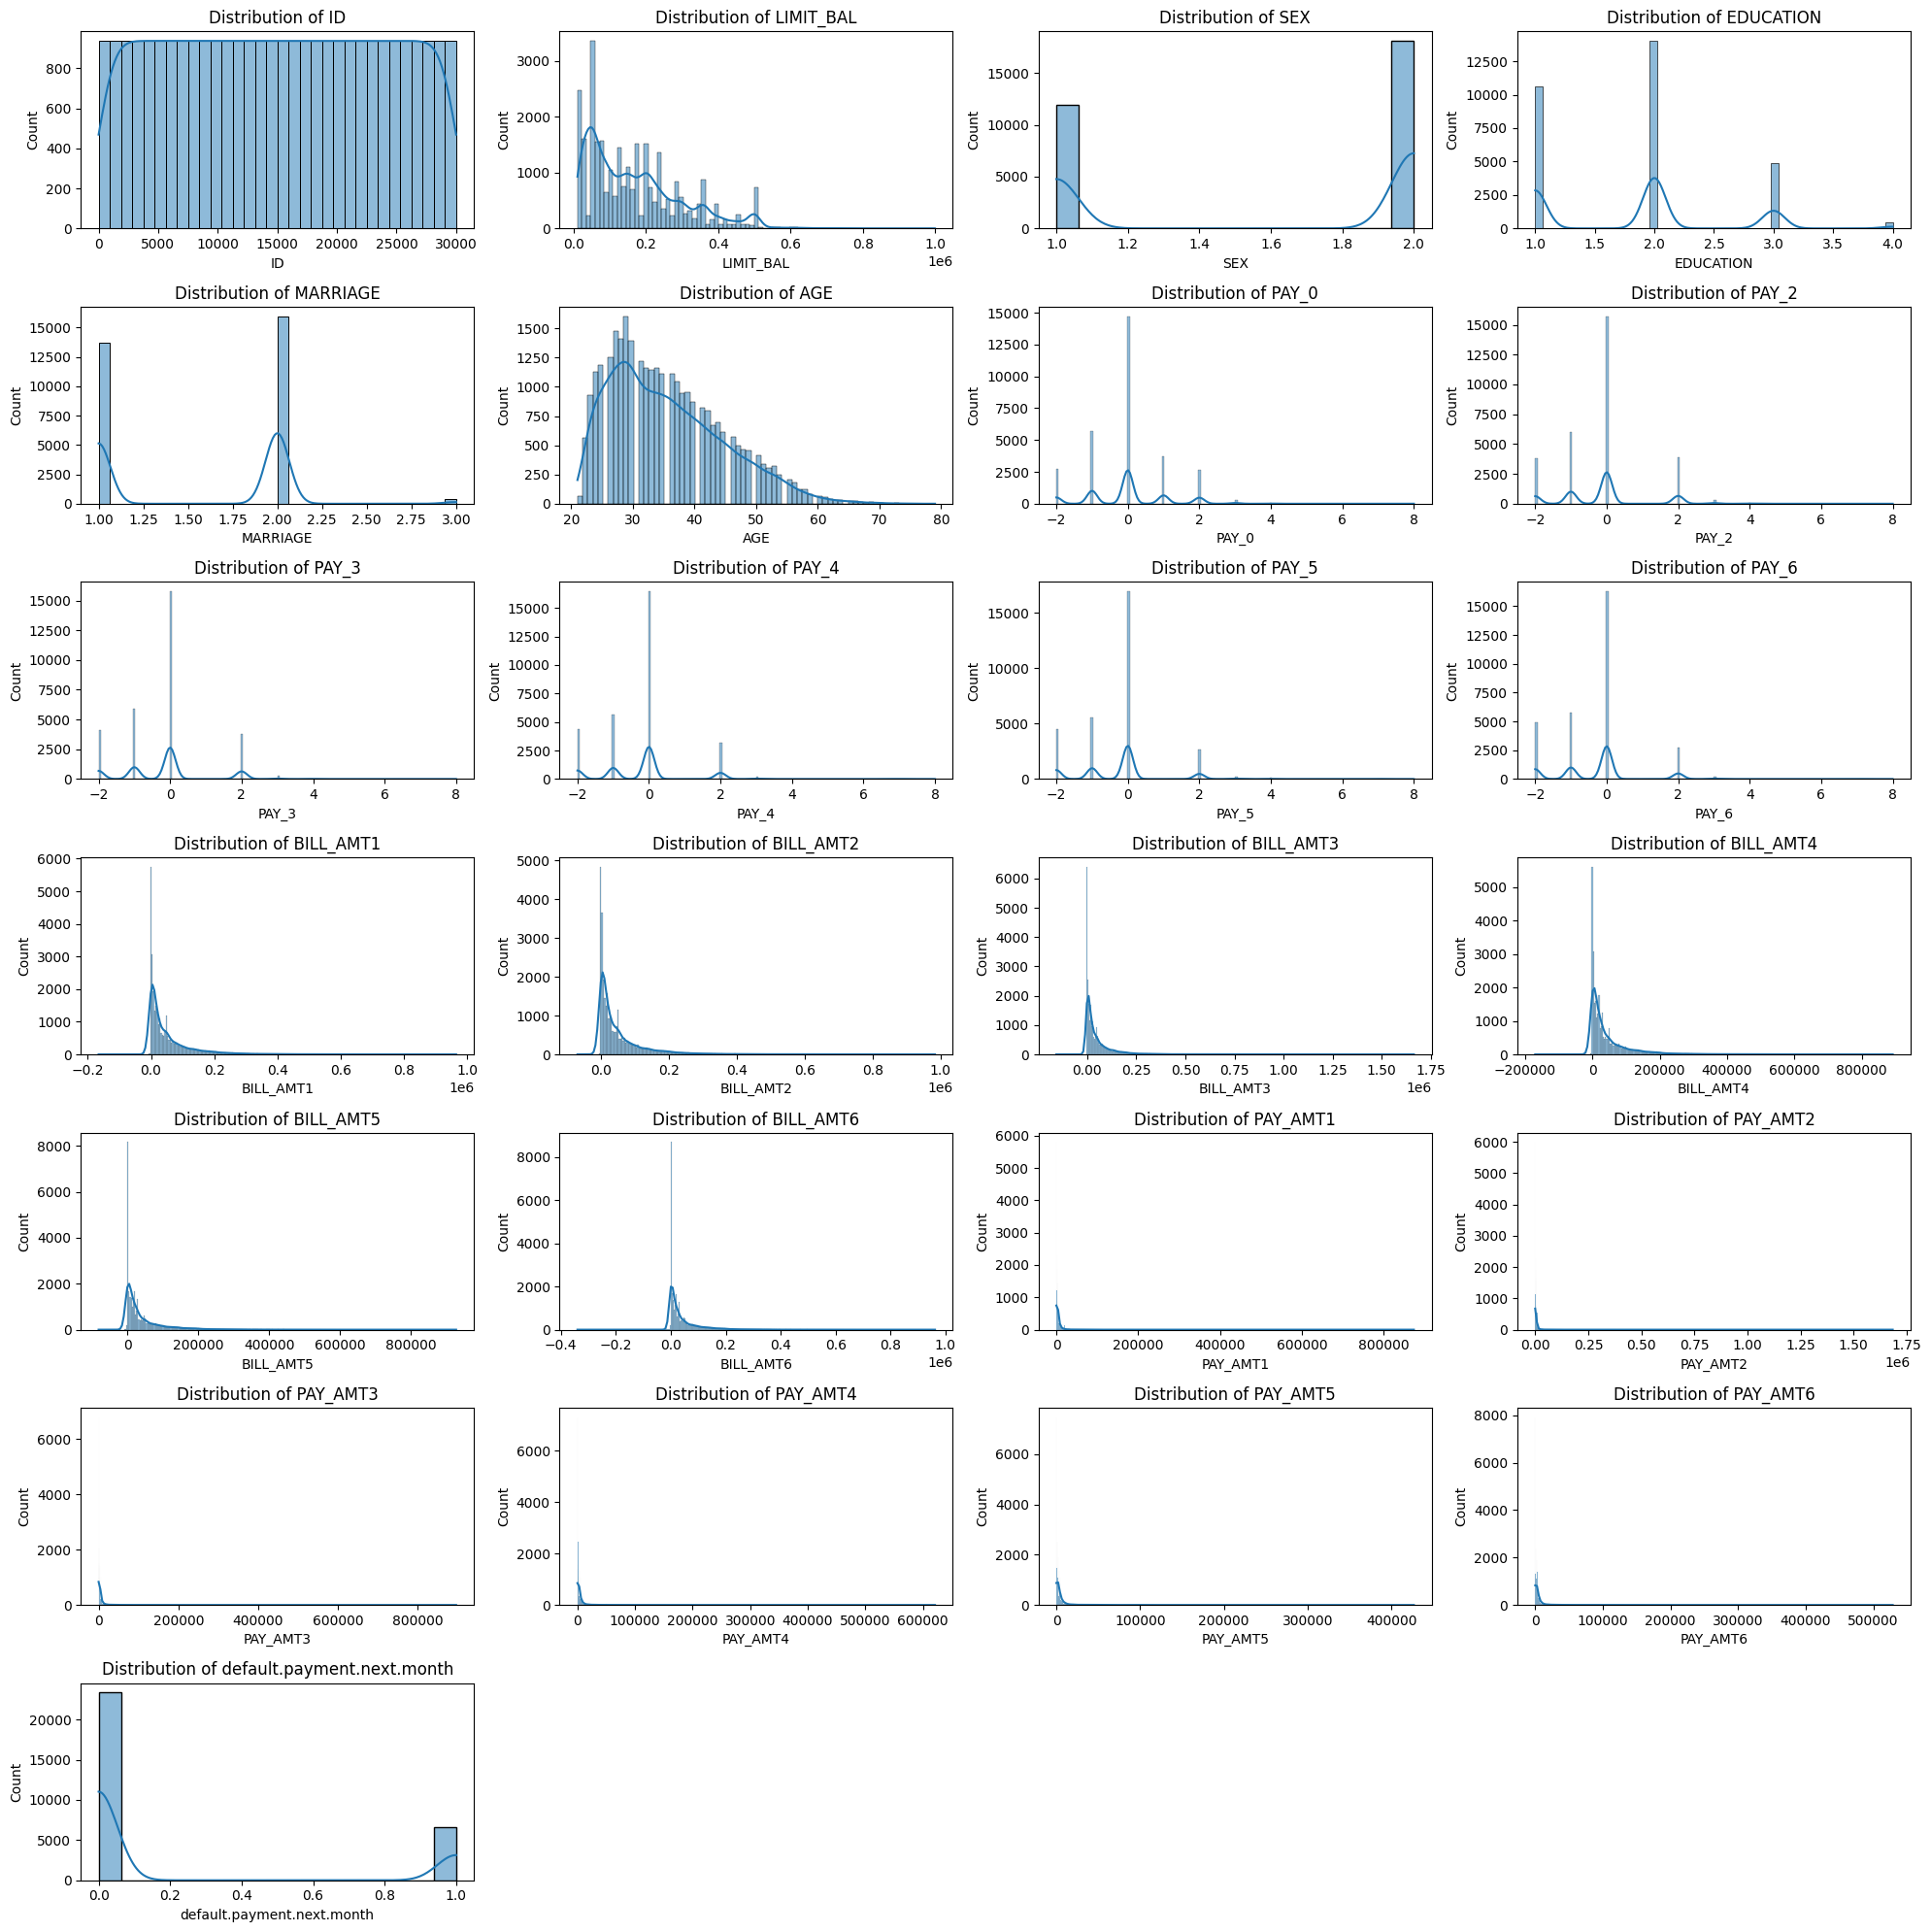

In [71]:
numerical_features = data.select_dtypes(include=['float64', 'int64']).columns

plt.figure(figsize=(20, 20))
for i, col in enumerate(numerical_features, 1):
    plt.subplot(7, 4, i)
    sns.histplot(data[col], kde=True)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

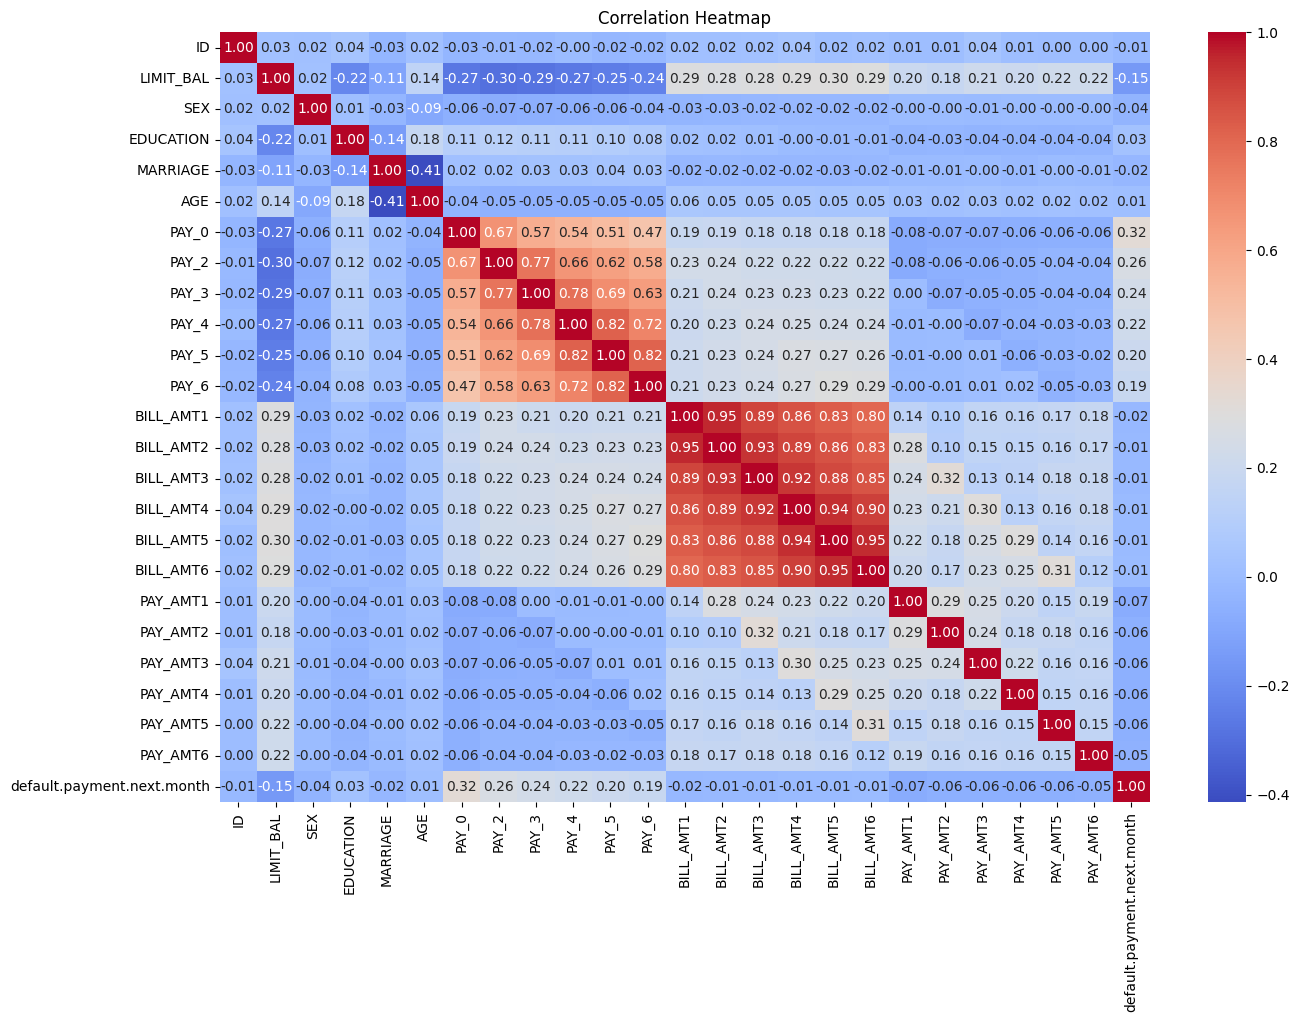

In [13]:
plt.figure(figsize=(15, 10))
correlation_matrix = data.corr()
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

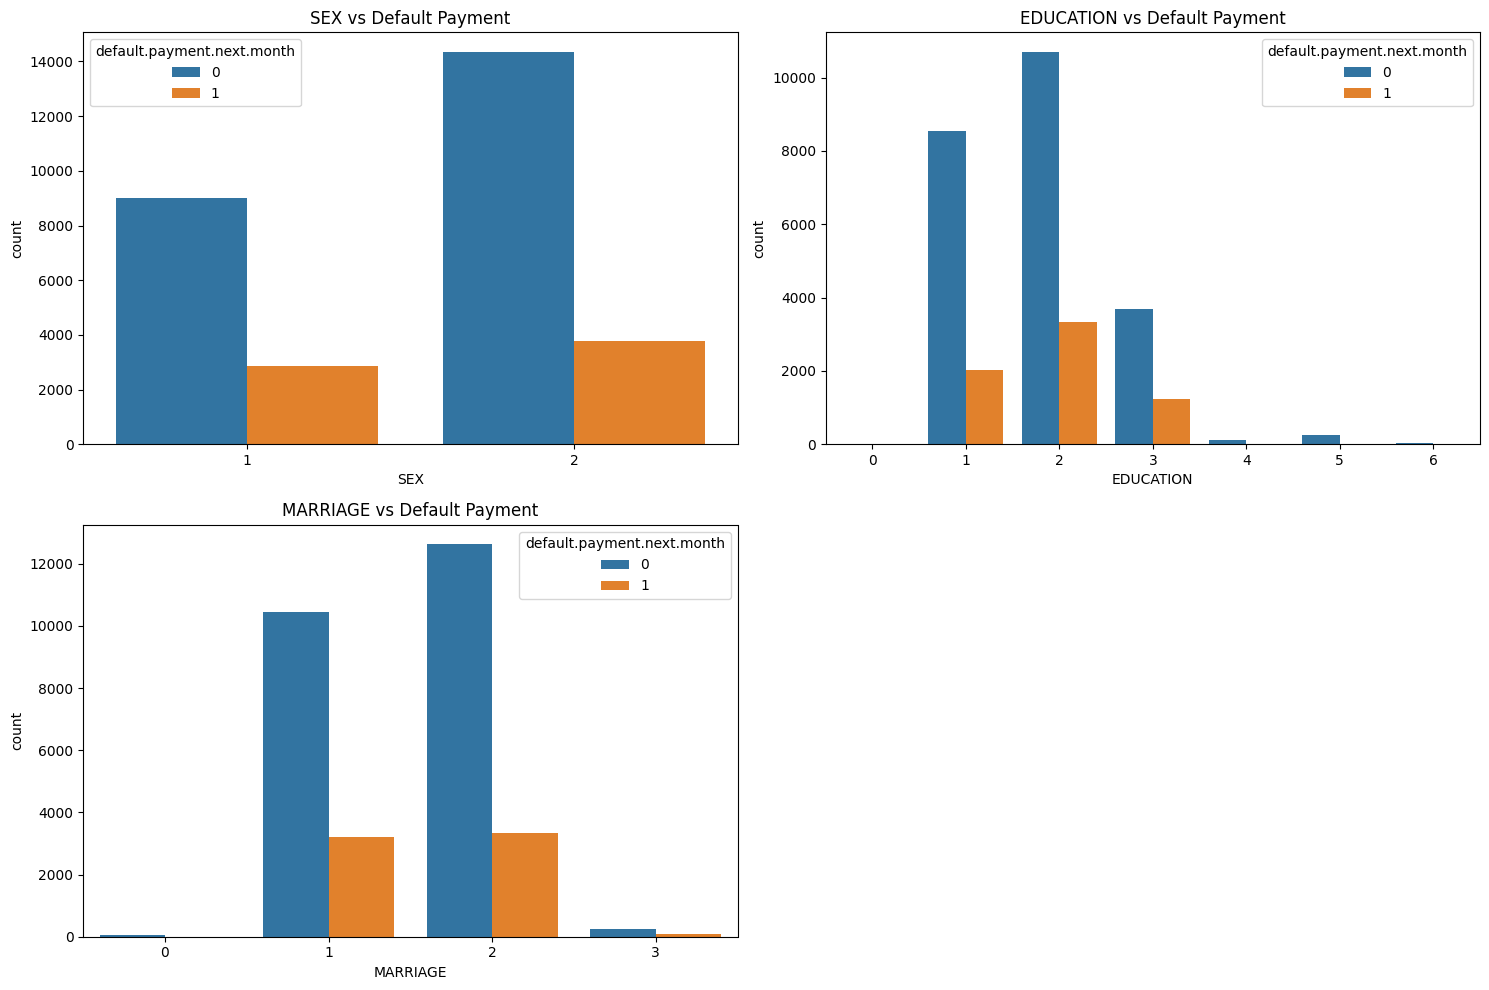

In [15]:
categorical_features = ['SEX', 'EDUCATION', 'MARRIAGE']

plt.figure(figsize=(15, 10))
for i, col in enumerate(categorical_features, 1):
    plt.subplot(2, 2, i)
    sns.countplot(x=data[col], hue=data['default.payment.next.month'])
    plt.title(f'{col} vs Default Payment')
plt.tight_layout()
plt.show()

---

In [16]:
# Separate features and target variable
X = data.drop(columns=['ID', 'default.payment.next.month'])
y = data['default.payment.next.month']

In [17]:
# Standardize numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [18]:
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)
X_scaled_df.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
0,-1.136720,0.810161,0.185828,-1.057295,-1.246020,1.794564,1.782348,-0.696663,-0.666599,-1.530046,...,-0.667993,-0.672497,-0.663059,-0.652724,-0.341942,-0.227086,-0.296801,-0.308063,-0.314136,-0.293382
1,-0.365981,0.810161,0.185828,0.858557,-1.029047,-0.874991,1.782348,0.138865,0.188746,0.234917,...,-0.639254,-0.621636,-0.606229,-0.597966,-0.341942,-0.213588,-0.240005,-0.244230,-0.314136,-0.180878
2,-0.597202,0.810161,0.185828,0.858557,-0.161156,0.014861,0.111736,0.138865,0.188746,0.234917,...,-0.482408,-0.449730,-0.417188,-0.391630,-0.250292,-0.191887,-0.240005,-0.244230,-0.248683,-0.012122
3,-0.905498,0.810161,0.185828,-1.057295,0.164303,0.014861,0.111736,0.138865,0.188746,0.234917,...,0.032846,-0.232373,-0.186729,-0.156579,-0.221191,-0.169361,-0.228645,-0.237846,-0.244166,-0.237130
4,-0.905498,-1.234323,0.185828,-1.057295,2.334029,-0.874991,0.111736,-0.696663,0.188746,0.234917,...,-0.161189,-0.346997,-0.348137,-0.331482,-0.221191,1.335034,0.271165,0.266434,-0.269039,-0.255187


In [19]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=0)

### Random Forest with all features

In [20]:
# Hyperparameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

In [21]:
rf = RandomForestClassifier(random_state=0)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   4.8s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   4.8s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   5.0s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   5.2s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   5.2s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   5.3s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   5.3s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   4.9s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=  10.0s
[CV] END ma

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=0), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5],
                         'n_estimators': [100, 200]},
             verbose=2)

In [22]:
random_forest = grid_search.best_estimator_

In [26]:
y_pred = random_forest.predict(X_test)
report = classification_report(y_test, y_pred)

print(report)

              precision    recall  f1-score   support

           0       0.84      0.95      0.90      7060
           1       0.68      0.36      0.47      1940

    accuracy                           0.82      9000
   macro avg       0.76      0.65      0.68      9000
weighted avg       0.81      0.82      0.80      9000



In [40]:
# Feature importance for the full model
importances_full = random_forest.feature_importances_
indices_full = np.argsort(importances_full)[::-1]

# Print the feature ranking
print("Feature ranking (all features):")
for f in range(X.shape[1]):
    print(f"{f + 1}. Feature {X.columns[indices_full[f]]} ({importances_full[indices_full[f]]})")

Feature ranking (all features):
1. Feature PAY_0 (0.23297560174936519)
2. Feature PAY_2 (0.12171177916402169)
3. Feature PAY_3 (0.06073705534792277)
4. Feature PAY_4 (0.0467560109860095)
5. Feature PAY_5 (0.046682700105270314)
6. Feature PAY_AMT1 (0.04161395775295614)
7. Feature PAY_6 (0.039927761636177554)
8. Feature BILL_AMT1 (0.03507513383627295)
9. Feature LIMIT_BAL (0.034863949955881844)
10. Feature PAY_AMT2 (0.03350356556725145)
11. Feature BILL_AMT2 (0.0325844340657787)
12. Feature PAY_AMT3 (0.03018625758892523)
13. Feature BILL_AMT3 (0.030114802239101554)
14. Feature BILL_AMT5 (0.02972923627457695)
15. Feature BILL_AMT4 (0.02926111574991783)
16. Feature PAY_AMT6 (0.02838070332622899)
17. Feature AGE (0.02790131755176037)
18. Feature BILL_AMT6 (0.026984020493262834)
19. Feature PAY_AMT5 (0.026477546283647124)
20. Feature PAY_AMT4 (0.025708554302499576)
21. Feature EDUCATION (0.00882643018008708)
22. Feature MARRIAGE (0.005051049860065554)
23. Feature SEX (0.004947015983018821)


### Lasso Regression

In [27]:
# Apply Lasso regression with cross-validation
lasso = LassoCV(cv=5, random_state=0)
lasso.fit(X_scaled, y)

LassoCV(cv=5, random_state=0)

In [34]:
# Select features with non-zero coefficients
selected_features = X.columns[(lasso.coef_ != 0)].tolist()
print("Selected Features:")
for i in selected_features:
    print(i)

Selected Features:
LIMIT_BAL
SEX
EDUCATION
MARRIAGE
AGE
PAY_0
PAY_2
PAY_3
PAY_4
PAY_5
PAY_6
BILL_AMT1
PAY_AMT1
PAY_AMT2
PAY_AMT3
PAY_AMT4
PAY_AMT5
PAY_AMT6


### Random Forest with Lasso Selected Features

In [35]:
# Split the data into training and testing sets using selected features
X_selected = X[selected_features]
X_train_sel, X_test_sel, y_train_sel, y_test_sel = train_test_split(X_selected, y, test_size=0.3, random_state=0)

In [36]:
# Perform GridSearchCV for hyperparameter tuning
rf = RandomForestClassifier(random_state=0)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train_sel, y_train_sel)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   3.8s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   3.8s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   3.9s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   4.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   4.2s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   4.2s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   4.3s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   4.3s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   4.3s
[CV] END ma

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=0), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5],
                         'n_estimators': [100, 200]},
             verbose=2)

In [37]:
# Best model
random_forest_lasso = grid_search.best_estimator_

In [39]:
# Evaluate the model
y_pred_sel = random_forest_lasso.predict(X_test_sel)
report_sel = classification_report(y_test_sel, y_pred_sel)

print(report_sel)

              precision    recall  f1-score   support

           0       0.84      0.95      0.90      7060
           1       0.68      0.36      0.47      1940

    accuracy                           0.83      9000
   macro avg       0.76      0.66      0.68      9000
weighted avg       0.81      0.83      0.80      9000



In [41]:
# Feature importance for the reduced model
importances_sel = random_forest_lasso.feature_importances_
indices_sel = np.argsort(importances_sel)[::-1]

# Print the feature ranking
print("Feature ranking (selected features):")
for f in range(X_selected.shape[1]):
    print(f"{f + 1}. Feature {X_selected.columns[indices_sel[f]]} ({importances_sel[indices_sel[f]]})")

Feature ranking (selected features):
1. Feature PAY_0 (0.2541390036631694)
2. Feature PAY_2 (0.12173123288971605)
3. Feature PAY_3 (0.08150610143509275)
4. Feature BILL_AMT1 (0.055813298988622244)
5. Feature PAY_AMT1 (0.052748584383026875)
6. Feature PAY_4 (0.04808373962979221)
7. Feature LIMIT_BAL (0.04403688400050941)
8. Feature PAY_6 (0.04378356292262757)
9. Feature PAY_AMT3 (0.04290669337945299)
10. Feature PAY_AMT2 (0.04251440087168775)
11. Feature AGE (0.03893074345200998)
12. Feature PAY_AMT6 (0.03823094561403514)
13. Feature PAY_5 (0.037408127592377674)
14. Feature PAY_AMT5 (0.03674514051566189)
15. Feature PAY_AMT4 (0.03541079605979633)
16. Feature EDUCATION (0.011559826403628294)
17. Feature MARRIAGE (0.007446081826470097)
18. Feature SEX (0.007004836372323488)


### Improved lasso

In [45]:
# Apply LassoCV with a wider range of alpha values
lasso_cv = LassoCV(alphas=np.logspace(-6, 0, 100), cv=10, random_state=0)
lasso_cv.fit(X_scaled, y)

LassoCV(alphas=array([1.00000000e-06, 1.14975700e-06, 1.32194115e-06, 1.51991108e-06,
       1.74752840e-06, 2.00923300e-06, 2.31012970e-06, 2.65608778e-06,
       3.05385551e-06, 3.51119173e-06, 4.03701726e-06, 4.64158883e-06,
       5.33669923e-06, 6.13590727e-06, 7.05480231e-06, 8.11130831e-06,
       9.32603347e-06, 1.07226722e-05, 1.23284674e-05, 1.41747416e-05,
       1.62975083e-05, 1.87381742e-0...
       4.03701726e-02, 4.64158883e-02, 5.33669923e-02, 6.13590727e-02,
       7.05480231e-02, 8.11130831e-02, 9.32603347e-02, 1.07226722e-01,
       1.23284674e-01, 1.41747416e-01, 1.62975083e-01, 1.87381742e-01,
       2.15443469e-01, 2.47707636e-01, 2.84803587e-01, 3.27454916e-01,
       3.76493581e-01, 4.32876128e-01, 4.97702356e-01, 5.72236766e-01,
       6.57933225e-01, 7.56463328e-01, 8.69749003e-01, 1.00000000e+00]),
        cv=10, random_state=0)

In [49]:
# Apply LassoCV with a wide range of alpha values
lasso_cv = LassoCV(alphas=np.logspace(-6, 0, 100), cv=10, random_state=0)
lasso_cv.fit(X_scaled, y)

LassoCV(alphas=array([1.00000000e-06, 1.14975700e-06, 1.32194115e-06, 1.51991108e-06,
       1.74752840e-06, 2.00923300e-06, 2.31012970e-06, 2.65608778e-06,
       3.05385551e-06, 3.51119173e-06, 4.03701726e-06, 4.64158883e-06,
       5.33669923e-06, 6.13590727e-06, 7.05480231e-06, 8.11130831e-06,
       9.32603347e-06, 1.07226722e-05, 1.23284674e-05, 1.41747416e-05,
       1.62975083e-05, 1.87381742e-0...
       4.03701726e-02, 4.64158883e-02, 5.33669923e-02, 6.13590727e-02,
       7.05480231e-02, 8.11130831e-02, 9.32603347e-02, 1.07226722e-01,
       1.23284674e-01, 1.41747416e-01, 1.62975083e-01, 1.87381742e-01,
       2.15443469e-01, 2.47707636e-01, 2.84803587e-01, 3.27454916e-01,
       3.76493581e-01, 4.32876128e-01, 4.97702356e-01, 5.72236766e-01,
       6.57933225e-01, 7.56463328e-01, 8.69749003e-01, 1.00000000e+00]),
        cv=10, random_state=0)

In [50]:
# Selected features with non-zero coefficients
selected_features = X.columns[(lasso_cv.coef_ != 0)].tolist()
print("Selected Features with Lasso:")
for i in selected_features:
    print(i)

Selected Features with Lasso:
LIMIT_BAL
SEX
EDUCATION
MARRIAGE
AGE
PAY_0
PAY_2
PAY_3
PAY_4
PAY_5
PAY_6
BILL_AMT1
PAY_AMT1
PAY_AMT2
PAY_AMT3
PAY_AMT4
PAY_AMT5
PAY_AMT6


In [51]:
# Apply RFE with Lasso for further feature selection
lasso_best = Lasso(alpha=lasso_cv.alpha_)
rfe = RFE(estimator=lasso_best, n_features_to_select=10, step=1)
rfe.fit(X_scaled, y)


RFE(estimator=Lasso(alpha=0.0012328467394420659), n_features_to_select=10)

In [53]:
# Selected features with RFE
selected_features_rfe = X.columns[rfe.support_].tolist()
print("Selected Features with RFE:")
for i in selected_features_rfe:
    print(i)

Selected Features with RFE:
LIMIT_BAL
EDUCATION
MARRIAGE
AGE
PAY_0
PAY_2
PAY_3
PAY_5
BILL_AMT1
PAY_AMT1


In [54]:
# Random Forest with selected features
rf_sel = RandomForestClassifier(random_state=0)
grid_search_sel = GridSearchCV(estimator=rf_sel, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search_sel.fit(X_train_sel, y_train_sel)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   3.5s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   3.7s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   3.8s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   3.8s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   3.9s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   4.0s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   4.0s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   4.0s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   7.7s
[CV] END ma

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=0), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5],
                         'n_estimators': [100, 200]},
             verbose=2)

In [55]:
# Best model
best_rf_sel = grid_search_sel.best_estimator_

In [56]:
# Evaluate the model
y_pred_sel = best_rf_sel.predict(X_test_sel)
report_sel = classification_report(y_test_sel, y_pred_sel)

print("Random Forest with Optimized Lasso Selected Features:\n", report_sel)

Random Forest with Optimized Lasso Selected Features:
               precision    recall  f1-score   support

           0       0.84      0.95      0.90      7060
           1       0.68      0.36      0.47      1940

    accuracy                           0.83      9000
   macro avg       0.76      0.66      0.68      9000
weighted avg       0.81      0.83      0.80      9000

